## Part3: 深度卷积网络演示

在Part2部分，我们实验了自己开发基于Torch的算法。在这一部分，我们直接使用Torch带的强大的神经网络实现包，实验一个与LeNet类似的卷积网络，识别一张64x64的手势图像。

### 0. 装载数据

总样本数目：2400	


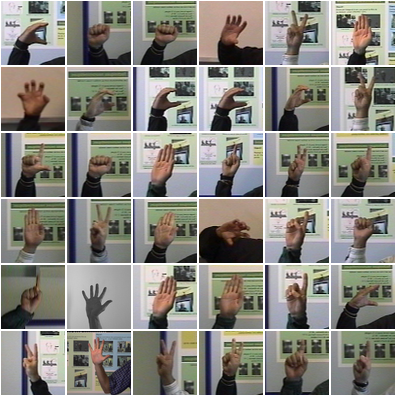

In [1]:
_CUDA_ = false

require('image')
require('./guestureData')

torch.setdefaulttensortype('torch.FloatTensor')

print('总样本数目：'.. #allSamples)
local guestures = {};
for i=1,36 do
    guestures[i] = image.loadPNG( allSamples[i].fileName, 3 );
end
itorch.image(guestures)

sampleLabel = {'A', 'B', 'C', 'Five', 'Point', 'V'}


### 1. 构造训练样本和测试样本

这里设置400个测试样本，2000个训练样本

In [7]:
if ( _CUDA_) then
require('cunn')
end


trainSamples = {}
for i = 1,2000 do
    allSamples[i].data = image.loadPNG( allSamples[i].fileName, 3 )
    allSamples[i].data = (allSamples[i].data-0.5)*2
    if (_CUDA_) then
        allSamples[i].data = allSamples[i].data:cuda()
    end
    trainSamples[i] = allSamples[i]
end

testSamples = {}
for i = 2001,2400 do
    allSamples[i].data = image.loadPNG( allSamples[i].fileName, 3 )
    allSamples[i].data = (allSamples[i].data-0.5)*2
    if (_CUDA_) then
        allSamples[i].data = allSamples[i].data:cuda()
    end
    testSamples[i-2000] = allSamples[i]
end


### 2. 设计卷积网络

卷积网络的不同于全连接网络，卷积层把输入看作二维多张图像，在X-Y面做滑动卷积，Z方向做线性组合，典型如图所示：
![卷积网络形式](./images/cnn.jpeg)

In [2]:
require('nn')
    
-- 构造一个卷积网络
model = nn.Sequential()
model:add(nn.SpatialConvolution(3, 8, 3, 3, 1, 1, 1)) -- 64x64
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2))
model:add(nn.SpatialConvolution(8, 16, 3, 3, 1, 1, 1))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2))
model:add(nn.SpatialConvolution(16, 16, 3, 3, 1, 1, 1))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2))
model:add(nn.Reshape(16*8*8))
model:add(nn.Linear(16*8*8, 6))



### 3. 设计训练方法

#### 3.1 设计Loss Function

这里使用 softmax 输出，相关计算如下：

$$
P(Y=i|x^n,W,b) = \text{softmax}(Wx^n+be) = \frac{ e^{Wx_i^n+b} }{ \sum_j e^{Wx_j^n+b} }
$$

In [3]:
-- 配合LogSoftMax使用的loss function
model:add(nn.LogSoftMax())

model:training()
criterion = nn.ClassNLLCriterion() 

if (_CUDA_) then
    model:cuda()
    criterion:cuda()
end

#### 3.2 设计训练函数


In [4]:
batchSize = 32
itemIndex = 1

-- 纪录模型的参数
parameters,gradParameters = model:getParameters()
doTrain = function(x)
  -- get new parameters
  if x ~= parameters then
    parameters:copy(x)
  end
  -- reset gradients
  gradParameters:zero()
  
  local f = 0 --error均值 
  for i=0,batchSize-1 do
    local targetIndex = (itemIndex + i) % #trainSamples + 1
    local targetSample = trainSamples[targetIndex].data
        
    -- 前向计算    
    local output = model:forward(targetSample)
    local err = criterion:forward(output, trainSamples[targetIndex].y)
    f = f + err
    
    -- 后向计算估计 df/dw
    local df_do = criterion:backward(output, trainSamples[targetIndex].y)
    model:backward(targetSample, df_do)    
  end
  
  gradParameters:div(batchSize)
  f = f/batchSize 
  
  return f, gradParameters
end

#### 3.3 设计优化算法

这里可以尝试使用sgd, asgd，adadelta等不同的优化算法。


In [5]:
require('optim')

optimMethod = optim.adadelta
optimState = {}

### 4.0 训练卷积网络
#### 4.1 试训练

我们首先固定一个小样本，进行训练，确保模型能够收敛，以下演示了一个试训练的过程：

In [8]:
local maxLoop = 30
local errRecord = {  --纪录每次训练的error输出
  seq = {},
  value = {}
}

optimState = {}
itemIndex = 1
for i=1,maxLoop do
  local err
  _, err = optimMethod(doTrain, parameters, optimState)
  
  errRecord.value[i] = err
  errRecord.seq[i] = i
end

Plot = require 'itorch.Plot'
local plot = Plot()
plot:line(errRecord.seq, errRecord.value,'black', 'yolo'):draw()
plot:title("小样本测试"):redraw()

#### 4.2 全样本训练，以及测试集监控


In [9]:
trainRecord = {  --纪录每次训练的error输出
  seq = {},
  value = {}
}

testRecord = {
   value = {},
   pred = {}
}

oneEpochs = function() 
    local maxLoop = math.floor(#trainSamples/batchSize)
    itemIndex = 1
    
    local err
    for i= 1, maxLoop+1 do
      _, err = optimMethod(doTrain, parameters, optimState)
      
      itemIndex = itemIndex + batchSize
      if (itemIndex > #trainSamples) then
          itemIndex = 1
      end
        
      trainRecord.value[#trainRecord.value+1] = err
      trainRecord.seq[#trainRecord.seq+1] = #trainRecord.seq+1  
    end    
end

doTest = function()
  local f = 0
  local rightPred = 0
  local pred
  for i=1, #testSamples do 
    local targetSample = testSamples[i].data
    local output = model:forward(targetSample)
    
    _, pred = torch.max(output, 1)
    
    if ( pred[1] == testSamples[i].y ) then 
        rightPred = rightPred + 1
    end
        
    local err = criterion:forward(output, testSamples[i].y)
    f = f + err    
  end
  f = f / #testSamples
    
  table.insert(testRecord.value, f)
  table.insert(testRecord.pred, rightPred)
    
  return f, rightPred
end

In [17]:
-- trainRecord.seq = {}
-- trainRecord.value = {}
-- optimState = {}

local beginT = sys.clock()
oneEpochs()
doTest()
local endT = sys.clock()

print(">>>执行时间：" .. (endT-beginT))

local plot = Plot()
plot:line(trainRecord.seq, trainRecord.value,'black', 'yolo'):draw()
plot:title("全样本测试"):redraw()

for i=1, #testRecord.value do
  print("Epoches:" .. i .. " loss=" .. testRecord.value[i] .. " pred=" .. (testRecord.pred[i]/#testSamples) )
end

>>>执行时间：3.2778298854828	


Epoches:1 loss=0.84486471939861 pred=0.7425	
Epoches:2 loss=0.59736643817774 pred=0.82	
Epoches:3 loss=0.48855999831865 pred=0.8525	
Epoches:4 loss=0.43873035976149 pred=0.8925	
Epoches:5 loss=0.40122899652719 pred=0.9025	
Epoches:6 loss=0.38806043168078 pred=0.9	
Epoches:7 loss=0.37273205979247 pred=0.91	
Epoches:8 loss=0.38376407950837 pred=0.91	


#### 4.3 可视化测试


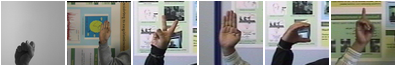

1>>>>>>>>>>>: A *** A	
2>>>>>>>>>>>: B *** B	
3>>>>>>>>>>>: V *** V	
4>>>>>>>>>>>: B *** B	
5>>>>>>>>>>>: C *** C	
6>>>>>>>>>>>: Point *** Point	


In [18]:
local testImages = {}
local testResult = {}
local testValue = {}
for i = 1,6 do
    local index = math.floor( math.random() * #testSamples) + 1
    local targetSample = testSamples[index].data
    local output = model:forward(targetSample)
    local result
    
    _, result = torch.max(output, 1)
    
    table.insert(testValue, testSamples[index].y )
    table.insert(testImages, targetSample)
    table.insert(testResult, result)
end

itorch.image(testImages)
for i = 1, #testResult do
    print(i .. ">>>>>>>>>>>: " .. sampleLabel[testValue[i]] .." *** ".. sampleLabel[testResult[i][1]] )
end
